In [1]:
import pandas as pd 
import numpy as np 
from os import chdir

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc, pyplot

import matplotlib
matplotlib.rc('axes',unicode_minus=False)

from datetime import date
import datetime 
import seaborn as sns

# MCO 데이터 불러오기

In [2]:
chdir('C:/Users/82105/Desktop/kdx')
mco = pd.read_csv('MCO_full_data.csv', 
                  names=['구매날짜','카테고리명','고객성별','고객나이','OS유형','구매금액','구매수'])

# 전처리

In [3]:
mco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837832 entries, 0 to 1837831
Data columns (total 7 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   구매날짜    int64 
 1   카테고리명   object
 2   고객성별    object
 3   고객나이    int64 
 4   OS유형    object
 5   구매금액    int64 
 6   구매수     int64 
dtypes: int64(4), object(3)
memory usage: 98.2+ MB


> 데이트 타입 변경 (구매날짜)

In [4]:
mco['구매날짜'] = pd.to_datetime(mco['구매날짜'].astype(str),format='%Y%m%d')

> 데이터 일치 (연령대) (기준 : 삼성카드)

In [5]:
# 1) 고객나이 음수 or 10세 이하 or 100세 이상 행 제거
index_minus = mco[(mco['고객나이']<=10) | (mco['고객나이']>=100) ].index
mco = mco.drop(index_minus)

# 2) 연령대 일치 (20대 ~ 60대이상)
index7890 = mco[ (mco['고객나이']==70) | (mco['고객나이']==80) | (mco['고객나이']==90) ].index
mco.loc[index7890,'고객나이'] = 60

# 3) 전체 연령대 : mco,  5060 연령대 : mco_5060
mco_5060 = mco[ (mco['고객나이']==50) | (mco['고객나이']==60) ]
mco_5060.columns

#mco['고객나이'].value_counts()
#mco['고객나이'].unique()

Index(['구매날짜', '카테고리명', '고객성별', '고객나이', 'OS유형', '구매금액', '구매수'], dtype='object')

> 데이터 년도별 그룹화

In [6]:
mco_5060 = mco_5060.set_index('구매날짜')
mco_5060_series = mco_5060.groupby('구매날짜').sum()
mco_5060_series.head()

,고객나이,구매금액,구매수
구매날짜,,,
2019-01-01,77800,6999735050,83795
2019-01-02,80930,9780026783,109777
2019-01-03,80460,9108779383,105439
2019-01-04,76850,7679794443,91157
2019-01-05,75680,5967475913,75508


In [7]:
mco_5060_series.to_csv('mco5060.csv', mode='w')

# 신한카드 데이터 불러오기

In [8]:
chdir('C:/Users/82105/Desktop/kdx')
df = pd.read_csv('Shinhancard.csv')

In [9]:
df['카드이용건수(천건)'] = df['카드이용건수(천건)'].apply(pd.to_numeric,errors='coerce')

In [10]:
df['업종'][1].split('_')[1]

'일식/중식/양식'

In [11]:
# 1) 컬럼명 일치
df = df.rename({'일별' : '소비일자','연령대별':'연령대','업종':'소비업종','카드이용건수(천건)':'소비건수'},axis=1)

# 2) 연령대 일치 (20대 ~ 60대이상)
index70 = df[df['연령대']=='70대'].index
df.loc[index70,'연령대'] = "60대"

# 3) 소비업종 : 분류코드 지우고 업종명만 남기기
df['소비업종'] = [df['소비업종'][i].split('_')[1] for i in range(len(df)) ]

In [12]:
df['소비일자2'] = pd.to_datetime(df['소비일자'].astype(str), format='%Y %m %d')

In [13]:
shinhan_5060 = df[ (df['연령대']=='50대') | (df['연령대']=='60대') ]
shinhan_5060.columns

Index(['소비일자', '성별', '연령대', '소비업종', '소비건수', '소비일자2'], dtype='object')

In [14]:
shinhan_5060 = shinhan_5060.set_index('소비일자2')
shinhan_5060_series = shinhan_5060.groupby('소비일자2').sum()
shinhan_5060_series.head()

,소비일자,소비건수
소비일자2,,
2019-01-01,3533267675,7146.0
2019-01-02,3634218360,9272.0
2019-01-03,3634218540,9238.0
2019-01-04,3593838512,9572.0
2019-01-05,3533268375,9580.0


In [15]:
shinhan_5060_series.to_csv('shinhan5060.csv', mode='w')

# Prophet 모듈을 이용한 forecast 예측

### 신한카드 데이터 5060대 구매건수 예측

> 시계열 위한 데이터 처리

In [14]:
# 1) 데이터 유형을 ARIMA에 적합한 float로 변환
shinhan_5060_count = shinhan_5060_series.loc[:,'소비건수'].astype(np.float)

C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 48708 missing from cur

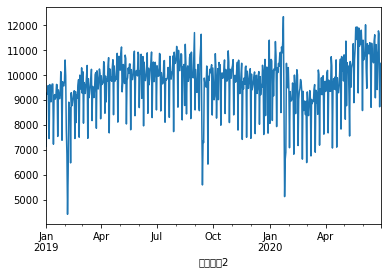

In [15]:
shinhan_5060_count.plot()
plt.show()

In [16]:
# 2) 나중에 참 값과 비교를 위해 일부 데이터 추출
mco_trunc1 = shinhan_5060_count[:'2019-12-31']
mco_trunc1

소비일자2
2019-01-01     7146.0
2019-01-02     9272.0
2019-01-03     9238.0
2019-01-04     9572.0
2019-01-05     9580.0
               ...   
2019-12-27    10321.0
2019-12-28    10071.0
2019-12-29     7675.0
2019-12-30    10308.0
2019-12-31    11399.0
Name: 소비건수, Length: 365, dtype: float64

In [17]:
# 3) dataframe 형태 및, columns ds와 y로 설정
df1 = pd.DataFrame({'ds' : mco_trunc1.index, 'y' : mco_trunc1.values})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      365 non-null    datetime64[ns]
 1   y       365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


> prophet모듈을 이용한 forecast 예측

In [18]:
from fbprophet import Prophet
import pandas as pd

m = Prophet(changepoint_range=0.8, changepoint_prior_scale=0.01)
m.fit(df1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
# 미래 dataframe 생성
future = m.make_future_dataframe(periods=182)
future.tail()

,ds
542,2020-06-26
543,2020-06-27
544,2020-06-28
545,2020-06-29
546,2020-06-30


In [20]:
# 예측
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
542,2020-06-26,10131.509974,9295.861367,11000.990259
543,2020-06-27,10182.930306,9317.020963,11039.673779
544,2020-06-28,7898.539277,7048.004549,8723.559090
545,2020-06-29,9905.089288,9056.149410,10749.557482
546,2020-06-30,9608.299386,8829.134546,10412.243125


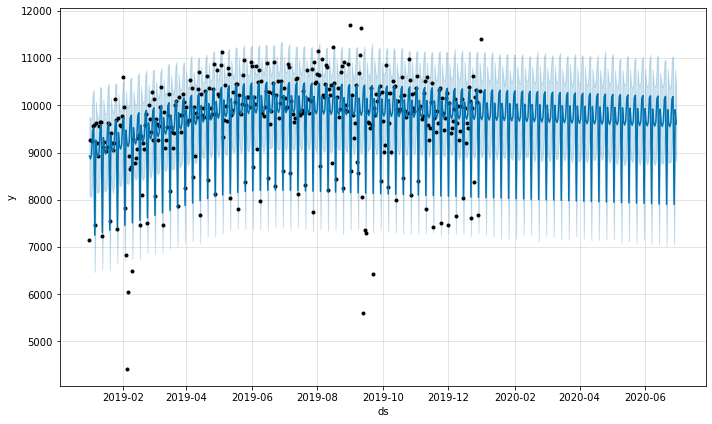

In [21]:
# 시각화
fig1 = m.plot(forecast)

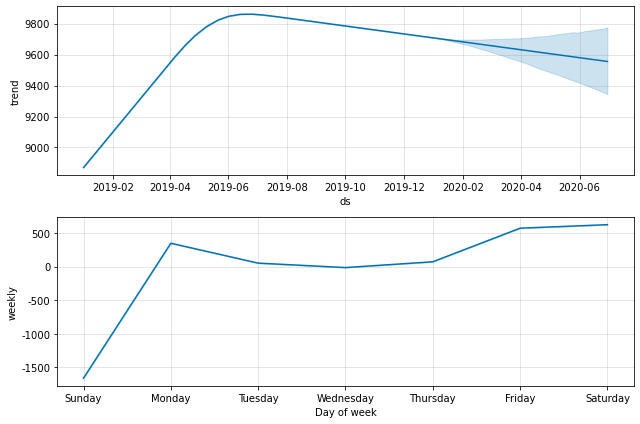

In [22]:
fig2 = m.plot_components(forecast)

In [23]:
shinhan_5060_count

소비일자2
2019-01-01     7146.0
2019-01-02     9272.0
2019-01-03     9238.0
2019-01-04     9572.0
2019-01-05     9580.0
               ...   
2020-06-26    11770.0
2020-06-27    11652.0
2020-06-28     8730.0
2020-06-29    10388.0
2020-06-30    10469.0
Name: 소비건수, Length: 547, dtype: float64

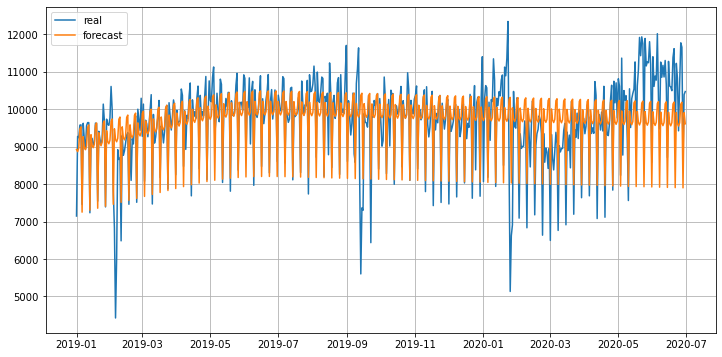

In [24]:
plt.figure(figsize=(12,6))
plt.plot(shinhan_5060_count.index, shinhan_5060_count.values, label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

In [25]:
y1 = forecast['yhat'] - shinhan_5060_count.values
y2 = pd.DataFrame(y1[365:])

index = forecast['ds'][365:]
y2.index = index
y2.head()

,yhat
ds,
2020-01-01,1629.393363
2020-01-02,-485.664882
2020-01-03,-349.498688
2020-01-04,-239.078357
2020-01-05,-136.469385


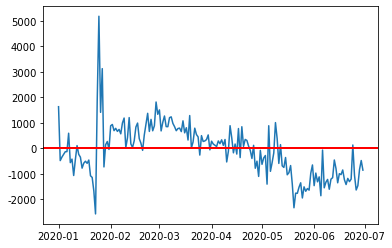

In [26]:
plt.plot(y2)
plt.axhline(y=0, color='r', linewidth=2)
plt.show()

In [27]:
print('2020-01-01 ~ 2020-06-31')
print('예측값 > 실제값 갯수 : ', y2[y2['yhat']>0].count())
print('예측값 < 실제값 갯수 : ', y2[y2['yhat']<0].count())
print('*'*50)
print('*'*50)
print('2020-01-01 ~ 2020-04-30')
y3 = y2.loc[:'2020-04-30']
print('예측값 > 실제값 갯수 : ', y3[y3['yhat']>0].count())
print('예측값 < 실제값 갯수 : ', y3[y3['yhat']<0].count())

2020-01-01 ~ 2020-06-31
예측값 > 실제값 갯수 :  yhat    90
dtype: int64
예측값 < 실제값 갯수 :  yhat    92
dtype: int64
**************************************************
**************************************************
2020-01-01 ~ 2020-04-30
예측값 > 실제값 갯수 :  yhat    85
dtype: int64
예측값 < 실제값 갯수 :  yhat    36
dtype: int64


### 구매수

In [28]:
# 1) 데이터 유형을 ARIMA에 적합한 float로 변환
mco_5060_count = mco_5060_series.loc[:,'구매수'].astype(np.float)

C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\82105\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 47588 missing from cur

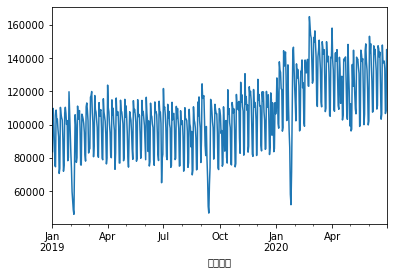

In [29]:
mco_5060_count.plot()
plt.show()

In [30]:
# 2) 나중에 참 값과 비교를 위해 일부 데이터 추출
mco_trunc2 = mco_5060_count[:'2019-12-31']
mco_trunc2

구매날짜
2019-01-01     83795.0
2019-01-02    109777.0
2019-01-03    105439.0
2019-01-04     91157.0
2019-01-05     75508.0
                ...   
2019-12-27    104932.0
2019-12-28     83729.0
2019-12-29     85650.0
2019-12-30    113227.0
2019-12-31    106387.0
Name: 구매수, Length: 365, dtype: float64

In [31]:
# 3) dataframe 형태 및, columns ds와 y로 설정
df2 = pd.DataFrame({'ds' : mco_trunc2.index, 'y' : mco_trunc2.values})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      365 non-null    datetime64[ns]
 1   y       365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [32]:
from fbprophet import Prophet
import pandas as pd

m = Prophet()
m.fit(df2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
# 미래 dataframe 생성
future = m.make_future_dataframe(periods=182)
future.tail()

,ds
542,2020-06-26
543,2020-06-27
544,2020-06-28
545,2020-06-29
546,2020-06-30


In [34]:
# 예측
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
542,2020-06-26,120351.956499,108829.095953,132583.615732
543,2020-06-27,102280.187709,90937.083532,113285.205964
544,2020-06-28,103289.943772,90943.711385,114413.327107
545,2020-06-29,137376.017424,125714.874787,148653.707891
546,2020-06-30,129938.835816,118072.889143,142288.453236


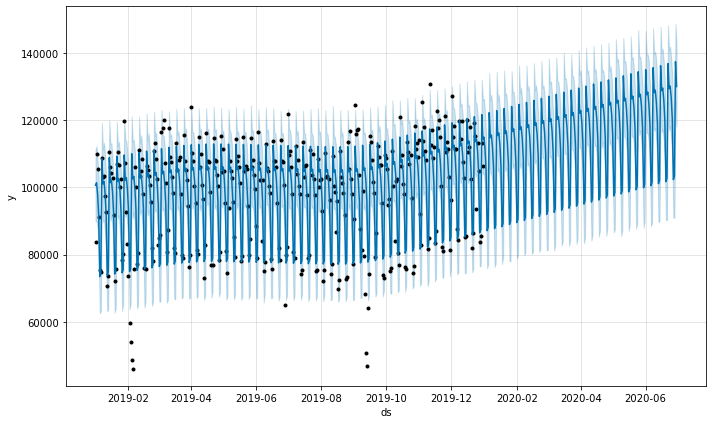

In [35]:
# 시각화
fig1 = m.plot(forecast)

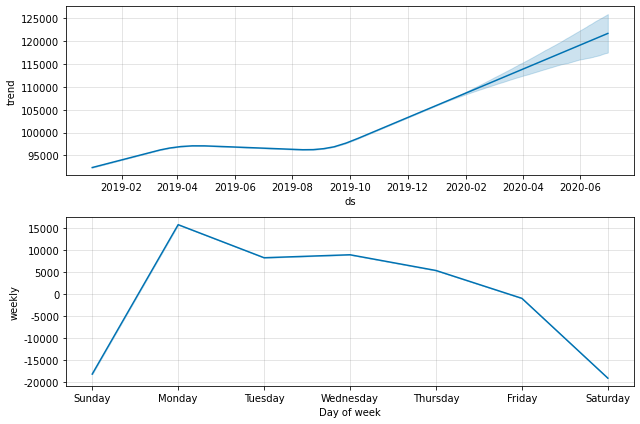

In [36]:
fig2 = m.plot_components(forecast)

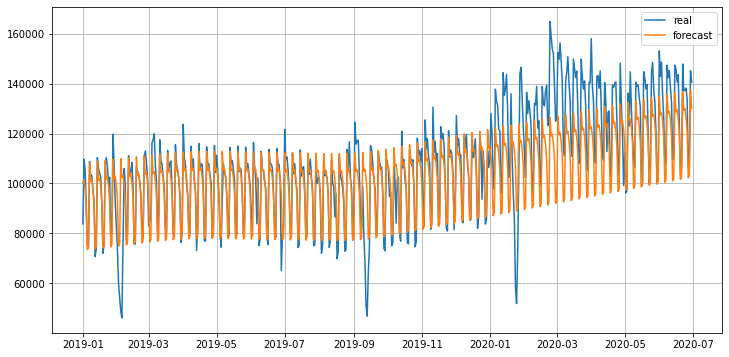

In [37]:
plt.figure(figsize=(12,6))
plt.plot(mco_5060_count.index, mco_5060_count.values, label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

In [42]:
y1 = forecast['yhat'] - mco_5060_count.values
y2 = pd.DataFrame(y1[365:])

index = forecast['ds'][365:]
y2.index = index
y2.head()

,yhat
ds,
2020-01-01,5635.460075
2020-01-02,-16676.181494
2020-01-03,-14729.710216
2020-01-04,-13514.479006
2020-01-05,-9777.722943


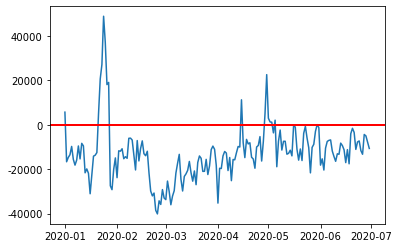

In [43]:
plt.plot(y2)
plt.axhline(y=0, color='r', linewidth=2)
plt.show()

In [44]:
print('2020-01-01 ~ 2020-06-31')
print('예측값 > 실제값 갯수 : ', y2[y2['yhat']>0].count())
print('예측값 < 실제값 갯수 : ', y2[y2['yhat']<0].count())
print('*'*50)
print('*'*50)
print('2020-01-01 ~ 2020-04-30')
y3 = y2.loc[:'2020-04-30']
print('예측값 > 실제값 갯수 : ', y3[y3['yhat']>0].count())
print('예측값 < 실제값 갯수 : ', y3[y3['yhat']<0].count())

2020-01-01 ~ 2020-06-31
예측값 > 실제값 갯수 :  yhat    16
dtype: int64
예측값 < 실제값 갯수 :  yhat    166
dtype: int64
**************************************************
**************************************************
2020-01-01 ~ 2020-04-30
예측값 > 실제값 갯수 :  yhat    11
dtype: int64
예측값 < 실제값 갯수 :  yhat    110
dtype: int64
